D’une part, on crée un environnement virtuel, on télécharge le fichier de données. 

Nous allons répondre à la problématique suivante: Quels facteurs influencent le plus le risque de surpoids ou d’obésité ?

On importe les bibliothèques.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Lecture du fichier

In [4]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


Vérification s'il y a des données manquantes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


Label Encoder sur le métier

In [6]:
le = LabelEncoder()
df['Occupation'] = le.fit_transform(df['Occupation'])

On sépare les données composées de blood presure en deux colonnes séparées.

In [7]:
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(df['Systolic_BP'])
df['Diastolic_BP'] = pd.to_numeric(df['Diastolic_BP'])
df.drop(columns=['Blood Pressure'], inplace=True)

Suppression de la colonne Sleep Disorder car trop de données manquantes et pas de lien directe avec notre problématique

In [8]:
df.drop(columns=['Sleep Disorder'], inplace=True)

on met le genre en valeur binaire 

In [9]:
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df['Gender_Male'] = df['Gender_Male'].astype(int)
df

,Person ID,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Systolic_BP,Diastolic_BP,Gender_Male
0,1,27,9,6.1,6,42,6,Overweight,77,4200,126,83,1
1,2,28,1,6.2,6,60,8,Normal,75,10000,125,80,1
2,3,28,1,6.2,6,60,8,Normal,75,10000,125,80,1
3,4,28,6,5.9,4,30,8,Obese,85,3000,140,90,1
4,5,28,6,5.9,4,30,8,Obese,85,3000,140,90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,59,5,8.1,9,75,3,Overweight,68,7000,140,95,0
370,371,59,5,8.0,9,75,3,Overweight,68,7000,140,95,0
371,372,59,5,8.1,9,75,3,Overweight,68,7000,140,95,0
372,373,59,5,8.1,9,75,3,Overweight,68,7000,140,95,0


on met notre variable cible sous forme binaire

In [10]:
df['BMI_binary'] = (df['BMI Category'] == 'Normal').astype(int)
df.drop(columns=['BMI Category'], inplace=True)

On sépare nos données en cible et le reste valeurs explicatif

In [11]:
y = df['BMI_binary']
X = df.drop(columns=['Person ID', 'BMI_binary']) #on prend pas en compte la colonne personne id car elle ne sert pas vraiment.

In [12]:
X

,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic_BP,Diastolic_BP,Gender_Male
0,27,9,6.1,6,42,6,77,4200,126,83,1
1,28,1,6.2,6,60,8,75,10000,125,80,1
2,28,1,6.2,6,60,8,75,10000,125,80,1
3,28,6,5.9,4,30,8,85,3000,140,90,1
4,28,6,5.9,4,30,8,85,3000,140,90,1
...,...,...,...,...,...,...,...,...,...,...,...
369,59,5,8.1,9,75,3,68,7000,140,95,0
370,59,5,8.0,9,75,3,68,7000,140,95,0
371,59,5,8.1,9,75,3,68,7000,140,95,0
372,59,5,8.1,9,75,3,68,7000,140,95,0


In [13]:
y

0      0
1      1
2      1
3      0
4      0
      ..
369    0
370    0
371    0
372    0
373    0
Name: BMI_binary, Length: 374, dtype: int64

On vérifie si les classes sont équilibrées

Text(0.5, 1.0, 'Distribution target')

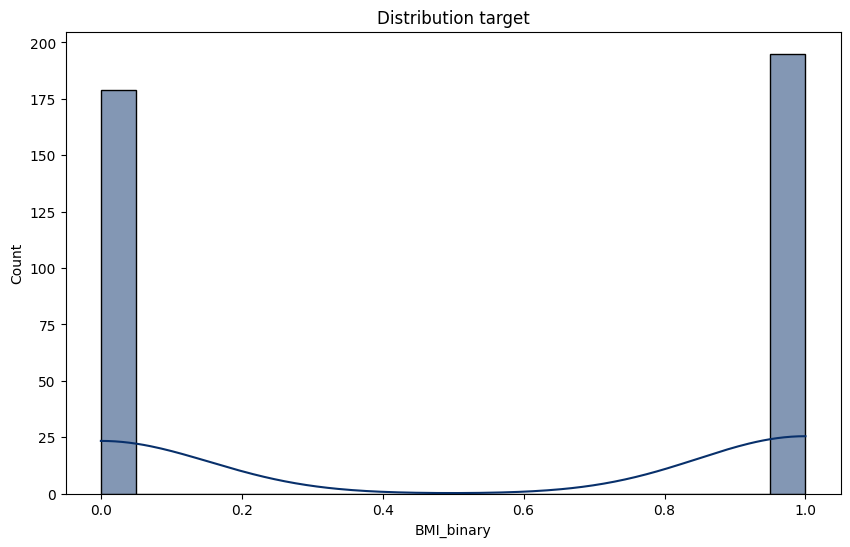

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(y,bins=20,color=plt.cm.Blues(1.0),edgecolor="black",kde=True)
plt.title("Distribution target")

On constate une bonne répartion.

Standardisation des données 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle =True,stratify=y)

Séparer les données, on garde 25% de données pour le test

In [16]:
num_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
            'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic_BP', 'Diastolic_BP']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Tracer de la matrice de correlation 

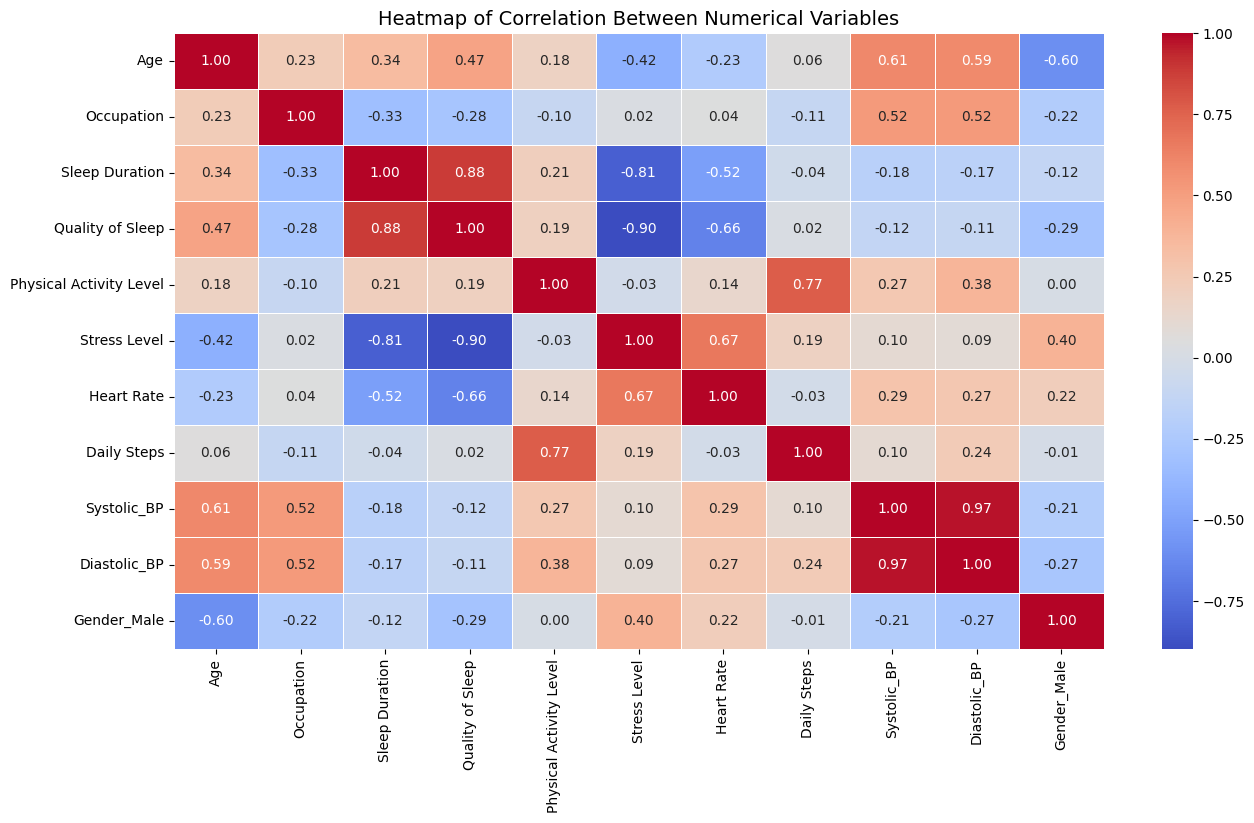

In [17]:
colmns = X.select_dtypes(include=['number'])
corr = colmns.corr()
plt.figure(figsize=(15, 8))  
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Correlation Between Numerical Variables", fontsize=14)
plt.show()

Afficher la taille des jeux de données

In [18]:
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (280, 11)
X_test shape is  (94, 11)
y_train shape is  (280,)
y_test shape is  (94,)


Regression logistique 

In [19]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [20]:
y_pred_logreg = logreg.predict(X_test)
y_train_pred_logreg = logreg.predict(X_train)
y_pred_logreg

array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1])

In [29]:
proba_df = pd.DataFrame({
    "Vrai_label": y_test.values,
    "Proba_surpoids": y_proba[:, 0],
    "Proba_normal": y_proba[:, 1],
    "Prediction": y_pred_logreg
})
proba_df #proba pour les valeurs test d'être en surpoids et d'être normal


,Vrai_label,Proba_surpoids,Proba_normal,Prediction
0,0,0.993629,0.006371,0
1,0,0.519992,0.480008,0
2,1,0.050429,0.949571,1
3,0,0.957135,0.042865,0
4,0,0.157810,0.842190,1
...,...,...,...,...
89,1,0.059830,0.940170,1
90,0,0.997644,0.002356,0
91,0,0.964648,0.035352,0
92,1,0.010592,0.989408,1


Evaluation du modèle 

In [21]:
print("Accuracy :", accuracy_score(y_test, y_pred_logreg))
print("Précision :", precision_score(y_test, y_pred_logreg))
print("Rappel :", recall_score(y_test, y_pred_logreg))
print("F1-score :", f1_score(y_test, y_pred_logreg))



Accuracy : 0.925531914893617
Précision : 0.875
Rappel : 1.0
F1-score : 0.9333333333333333


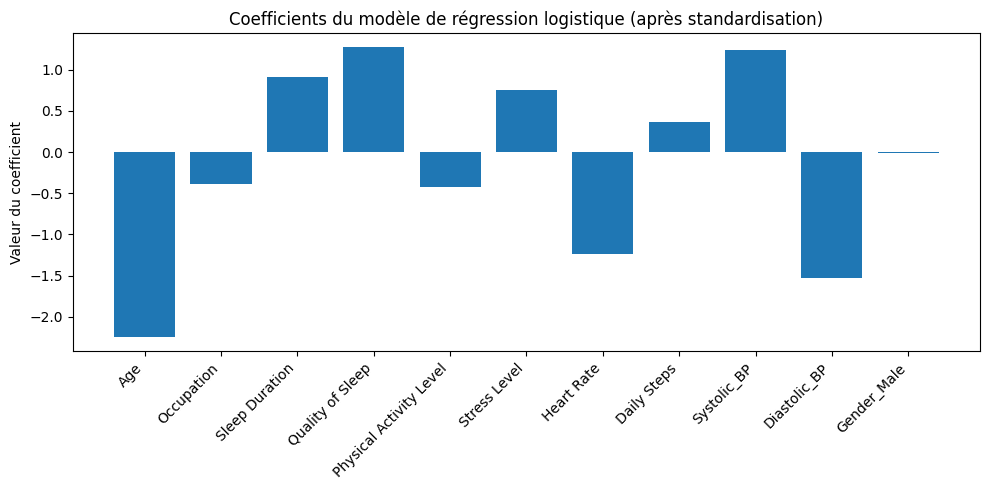

In [30]:
#Variables qui influencent le plus la prédiction
coefs = logreg.coef_[0] 
features = X.columns      # noms des variables explicatives

plt.figure(figsize=(10, 5))
plt.bar(features, coefs)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Valeur du coefficient")
plt.title("Coefficients du modèle de régression logistique (après standardisation)")
plt.tight_layout()
plt.show()


Explications

Variable cible (Y) : BMI CATERGORY 

BMI_binary = 1, IMC normal
BMI_binary = 0,surpoids ou obésité

Ce jeu de données contient plusieurs informations sur la santé et le mode de vie des individus. 
Les colonnes principales sont : Person ID (identifiant de chaque individu), Gender (homme/femme), Age, Occupation (profession), sleep Duration(durée de sommeil),
Quality of Sleep (qualité du sommeil), Physical Activity Level (niveau d’activité physique), Stress Level (niveau de stress perçu), BMI Category (IMC (normal, surpoids, obèse)),
Blood Pressure (tension artérielle), Heart Rate (fréquence cardiaque), Daily Steps (nombre moyen de pas par jour), Sleep Disorder (trouble du sommeil?).
Nous cherchons à identifier les facteurs qui influencent le plus le risque de surpoids ou d’obésité à partir de données liées au sommeil, à l’activité physique, au stress et à la santé générale. La régression logistique cherche à estimer la probabilité d’avoir un IMC normal en fonction des autres variables.

Ce jeu de données est intéressant pour la régression logistique car :
- la variable cible BMI est binaire,
- les variables explicatives sont à la fois continues et catégorielles.



Après avoir préparé le jeu de données (supression de colonnes inutiles, encodage des variables catégorielles , séparation du jeu de données, standardisation), on peut commencer la regression logistique.
On constate que la régression logistique prédit le BMI binaire (normal ou surpoids/obèse) et permet d’estimer l’influence de chaque variable.
On obtient une bonne accuracy de 0,93, un rappel de 1 et un F1-score de 0,93, le modèle identifie plutôt bien les individus.

Pour conclure, les facteurs qui influencent le plus le risque de surpoids ou d’obésité sont : l'âge, la diastolic_BBP et la qualité du sommeil.


Ce tp nous a permis de préparer les données, entraîner le modèle, et comprendre l’effet de chaque facteur sur le risque de surpoids grâce aux coefficients de la régression.
Le jeu de données n'est pas très grand, il serait pertinent de tester la regression sur un jeu de données plus grand.